In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf 
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

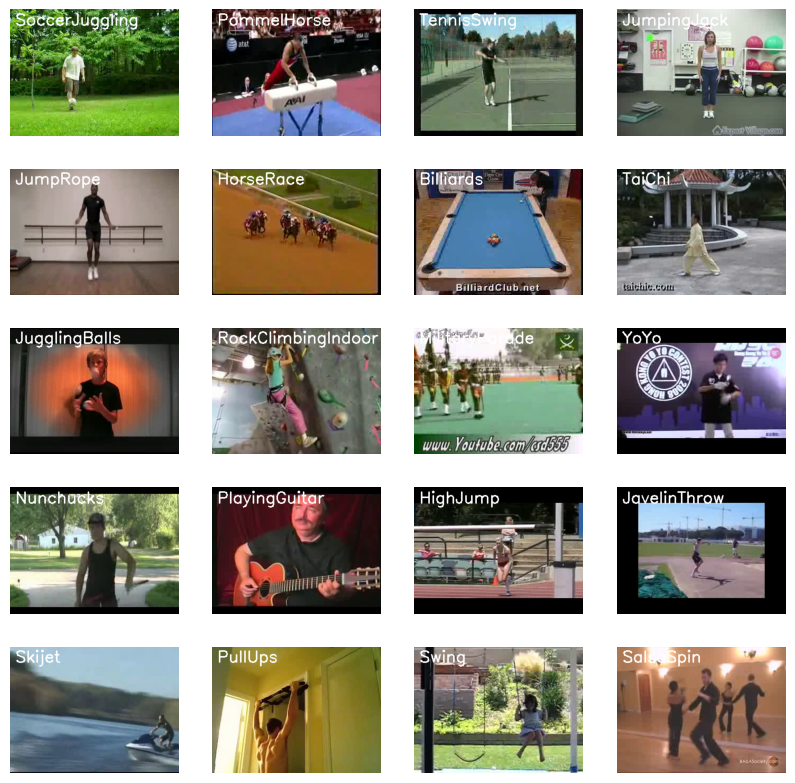

In [3]:
plt.figure(figsize=(10,10))

all_class_name = os.listdir('C:/Users/amite/OneDrive/Desktop/human/UCF50')

random_range = random.sample(range(len(all_class_name)), 20)

for count, index in enumerate(random_range,1):
  selected_class_name = all_class_name[index]
  video_name_list = os.listdir(os.path.join('C:/Users/amite/OneDrive/Desktop/human/UCF50', selected_class_name))
  selected_video_name = random.choice(video_name_list)

  video_reader = cv2.VideoCapture(os.path.join('C:/Users/amite/OneDrive/Desktop/human/UCF50', selected_class_name, selected_video_name))
  _, bgr_frame = video_reader.read()
  video_reader.release()
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
  plt.subplot(5, 4, count);plt.imshow(rgb_frame);plt.axis('off')

In [4]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "C:/Users/amite/OneDrive/Desktop/human/UCF50"
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [5]:
def frameextraction(video_path):
  frame_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_interval = max(int(video_frame_count/SEQUENCE_LENGTH),1)

  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_interval)
    success,frame = video_reader.read()
    if not success:
      break
    resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frame_list.append(normalized_frame)
  video_reader.release()
  return frame_list

In [6]:
def create_dataset():
  features = []
  labels = []
  video_file_path = []

  for class_index,class_name in enumerate(CLASSES_LIST):
    print(f'Extracting data of class {class_name}')

    file_list = os.listdir(os.path.join(DATASET_DIR,class_name))

    for file in file_list:
      video_path = os.path.join(DATASET_DIR,class_name,file)
      frames = frameextraction(video_path)

      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_file_path.append(video_path)

  features = np.asarray(features)
  labels = np.array(labels)

  return features,labels,video_file_path



In [7]:
features,labels,video_file_path = create_dataset()

Extracting data of class WalkingWithDog
Extracting data of class TaiChi
Extracting data of class Swing
Extracting data of class HorseRace


In [8]:
encode_labels = to_categorical(labels)

In [9]:
feature_train, feature_test, label_train, label_test = train_test_split(features, encode_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [10]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [11]:
convlstm_model = create_convlstm_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = feature_train, y = label_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback,reduce_lr])